# Gesture Based Writing Method
## Introduction
Hello surfer, welcome to this blog where I will be writing a Python code to write something in canvas by moving fingers in front of the camera. Nearly a year ago, I was doing this project but I thougt if I could use just contours then why use gestures? In that project, I used concept of background subtraction and then with the help of contour extraction, I wrote something on canvas. It was 6 part series of blogs and I hope you will find it interesting but I am going to do the same task except using the gestures except of contours and I am not planning on using VUI (Virtual User Interface) here too because if I can use gestures then why bother writng complex code?

* [Gesture Based Visually Writing System Using OpenCV and Python](https://q-viper.github.io/2020/08/01/gesture-based-visually-writing-system-using-opencv-and-python/)
* [Gesture Based Visually Writing System: Adding Visual User Interface](https://q-viper.github.io/2020/08/11/gesture-based-visually-writing-system-make-a-visual-user-interface/)
* [Gesture Based Visually Writing System: Adding Virtual Animationn, New Mode and New VUI](https://q-viper.github.io/2020/08/14/gesture-based-visually-writing-system-adding-virtual-animation-new-mode-and-new-vui/)
* [Gesture Based Visually Writing System: Add Slider, More Colors and Optimized OOP code](https://q-viper.github.io/2020/08/21/gesture-based-visually-writing-system-add-slider-more-colors-and-optimized-code/)
* [Gesture Based Visually Writing System: Building a Web App Using Flask](https://q-viper.github.io/2020/08/28/gesture-based-visually-writing-system-web-app/)

And here is the demo of that system:

<figure>
<video src = "https://q-viper.github.io/assets/contour-writing/web app.mp4" width="100%" controls autoplay loop> </video>
<figcaption style = "text-align:left; font-style:italic">Gesture writing on Web App</figcaption>
</figure> 


### What will be the difference?
Everything will eb different in this project but the end goal is somewhat similar. I will use concept of gestures from earlier projects.

## Preliminary Actions
### Imports

In [1]:
import mediapipe as mp
import cv2
import numpy as np
import matplotlib.pyplot as plt



### Common Functions
We will need to map our finger landmarks from pixel world to the new canvas world.

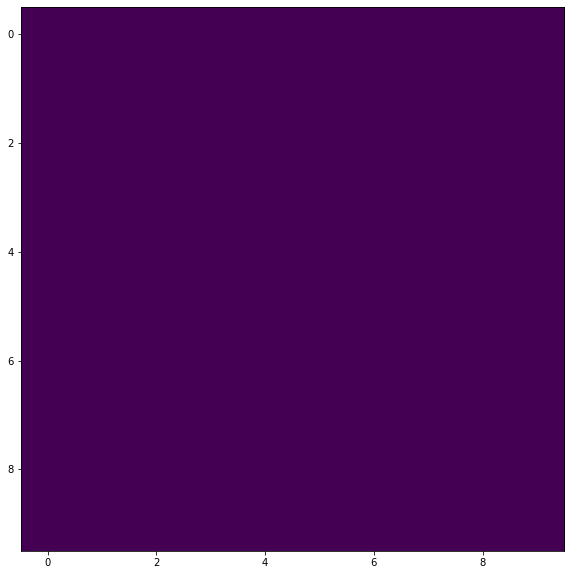

5.0

In [2]:
def show(img, fsize=(10, 10)):
    figure = plt.figure(figsize=fsize)
    plt.imshow(img)
    plt.show()
show(np.zeros((10, 10)))

def frame_pos2screen_pos(frame_size=(480, 640), screen_size=(768, 1366), frame_pos=None):
    
    x,y = screen_size[0]/frame_size[0], screen_size[1]/frame_size[1]
    
    screen_pos = [frame_pos[0]*y, frame_pos[1]*x]
    
    return np.array(screen_pos).astype(np.uint32)

def euclidean(pt1, pt2):
    d = np.sqrt((pt1[0]-pt2[0])**2+(pt1[1]-pt2[1])**2)
    return d
euclidean((4, 3), (0, 0))

## Gesture Writing Code Explained

* Define the video source and in our case, webcam.
```python
cam = cv2.VideoCapture(0)
```
* Define variables `fsize` as frame simze and `ssize` as screen size.
```python
fsize = (520, 720)
ssize = (520, 720)
```
* Define a background color.
```python
bg_color = (100, 100, 100)
```
* Define a pen size and ink size, pen will be a simple cursor like circle and ink will be a actual circle or written pixel.
```python
pen_size = 8
ink_size = 10
```
* Define colors in a dictionary format as {color_name: color_value}.
```python
colors = {"red": [0, 0, 255], "blue":[255, 0, 0], "green":[0, 255, 0]}
```
* Define modes, write, move and erase. 
```python
modes = ["write", "move", "erase"]
```
* Define variables for storing current mode, last_mode and current_color.
```python
current_mode = "draw"
last_mode = None
current_color = "red"
```
* Define some rules to take pen color, currently pen color will be color next to the draw color.
```python
cnames = list(colors.keys())
ink_color = colors[current_color]
pen_color = np.array(ink_color)-[100, 50, 100]
pen_color = pen_color.astype(np.uint8).tolist()
```
* Define hand and drawing module of mediapipe.
```python
mp_drawing = mp.solutions.drawing_utils
mp_hands = mp.solutions.hands
```
* Define variables for ROI rectangle.
```python
left, top, right, bottom = (400, 100, 700, 300)
```
* Define a canvas of blank image and then add background color.
```python
canvas = np.zeros((ssize[0], ssize[1], 3))+bg_color
canvas = canvas.astype(np.uint8)
```
* Define variables for checking every n frames and initialize check count.
```python
check_every = 5
check_cnt = 0
```
* Define hands module. Use maximum number of hands as 1.
```python
with mp_hands.Hands(static_image_mode=True,
                   max_num_hands = 1,
                   min_detection_confidence=0.2) as hands:
```
* While camera is opened perform operations like read frame.
```python
    while cam.isOpened():
        ret, frame = cam.read()
        if not ret:
            continue
```
* Add some Gaussian Blur.
```python
        frame = cv2.GaussianBlur(frame, (5, 5), -1)
```
* Define a temporary canvas for drawing and pointer. A `temp_canvas` is a canvas that we define in every frame and add new changes into it. Similarly, we will use `pen_canvas` just to view pointer. Both should be of `uint8`.
```python
        temp_canvas = np.zeros((ssize[0], ssize[1], 3)).astype(np.uint8)
        pen_canvas = np.zeros((ssize[0], ssize[1], 3)).astype(np.uint8)
```
* Flip the frame to look like selfie frame and resize it to given size. Also take height and width of frame. We will use it later to convert landmark positions to frame world.
```python           
        frame = cv2.flip(frame, 1)
        frame = cv2.resize(frame, (fsize[1], fsize[0]))
        
        h, w, _ = frame.shape
```
* Convert image to RGB and process it to get a result.
```python
        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        res = hands.process(rgb)
```
* Check if hand landmarks has been found and if did, loop through each hand.
```python
        if res.multi_hand_landmarks:
            for hand_landmarks in res.multi_hand_landmarks:
```
* Take landmarks like:- index tip, thumb tip, middle finger tip etc from hand landmarks and convert it into our frame world.
```python
                index_tip = mp_drawing._normalized_to_pixel_coordinates(
                    hand_landmarks.landmark[mp_hands.HandLandmark.INDEX_FINGER_TIP].x,
                    hand_landmarks.landmark[mp_hands.HandLandmark.INDEX_FINGER_TIP].y,
                    w, h)
                
                index_pip = np.array(mp_drawing._normalized_to_pixel_coordinates(
                    hand_landmarks.landmark[mp_hands.HandLandmark.INDEX_FINGER_PIP].x, 
                    hand_landmarks.landmark[mp_hands.HandLandmark.INDEX_FINGER_PIP].y, 
                    w, h))
                
                thumb_tip = mp_drawing._normalized_to_pixel_coordinates(
                    hand_landmarks.landmark[mp_hands.HandLandmark.THUMB_TIP].x, 
                    hand_landmarks.landmark[mp_hands.HandLandmark.THUMB_TIP].y, 
                    w, h)
                
                middle_tip = mp_drawing._normalized_to_pixel_coordinates(
                    hand_landmarks.landmark[mp_hands.HandLandmark.MIDDLE_FINGER_TIP].x, 
                    hand_landmarks.landmark[mp_hands.HandLandmark.MIDDLE_FINGER_TIP].y, 
                    w, h)            
```
* Convert index tip into canvas world. We will first make the list of index tip because we dont want to mess up with original values. Then we will clip the index tip value within the ROI rectangle. Then we will convert that clipped value to current frame world. Finally, we will convert those frame world landmarks to screen world.
```python
                index_tipm = list(index_tip) # make list
                index_tipm[0] = np.clip(index_tipm[0], left, right) # clip cloumn value within left to right
                index_tipm[1] = np.clip(index_tipm[1], top, bottom) # clip row value within top to bottom
                
                index_tipm[0] = (index_tipm[0]-left) * fsize[1]/(right-left) # column value from ROI to frame world
                index_tipm[1] = (index_tipm[1]-top) * fsize[0]/(bottom-top) # row value from ROI to frame world
                
                # convert coordinate from frame world to canvas or screen world
                screen_pos = frame_pos2screen_pos(fsize, ssize, index_tipm) 
```
* If check count is equal to check every.
```python
                if check_cnt >= check_every:
```
* If thumb tip and index pip is not none then check for distance between these points. If it is below 60 then check for current mode. If current mode is draw or erase then make it move else if current mode is move then make it draw. We want to simulate draw and move mode by single gesture. Something like our smartphone's power button's task to turn on/off display light.
```python
                    if thumb_tip is not None and index_pip is not None:
                        if euclidean(thumb_tip, index_pip)<60:
                            if current_mode == "draw" or current_mode == "erase":
                                current_mode = "move"
                                last_mode = "draw"
                            elif current_mode == "move":
                                current_mode="draw"
                                last_mode = "move"
```
* If middle tip and index tip is not none then check for distance between these points. If it is below 60 then check for current mode. If current mode is not erase then make it erase else make it move. We want to simulate erase and move mode by single gesture. Something like our smartphone's power button's task to turn on/off display light.
```python
                    if middle_tip is not None and index_tip is not None:
                        if euclidean(index_tip, middle_tip)<60:
                            if current_mode != "erase":
                                current_mode = "erase"
                            else:
                                current_mode = "move"
                                last_mode = "erase"
```
* If thumb tip and middle tip is not none then check for distance between these points. If it is below 60 then change the current ink color and pen color. The color will be changed in circular basis i.e clockwise.
```python
                    if thumb_tip is not None and middle_tip is not None:
                        if euclidean(thumb_tip, middle_tip)<60:
                            current_color = cnames[(cnames.index(current_color)+1)%len(cnames)]
                            ink_color = colors[current_color]
                            pen_color = np.array(ink_color)-[100, 50, 100]
                            pen_color = pen_color.astype(np.uint8).tolist()
                            # print(pen_color)
```
* Change check count to 0.
```python
                    check_cnt = 0
```
* Now perform the writing operation. If current mode is draw/erase then we will make a circle in temporary canvas on the screen position that we got after conversion of index tip. The radius will be of ink size. The color will be ink color while draw mode and background color in erase mode. At last, draw a cursor on a pen canvas with pen's size and color.
```python                
                if current_mode=="draw":
                    cv2.circle(temp_canvas, screen_pos, int(ink_size), ink_color, -1)
                if current_mode=="erase":
                    cv2.circle(temp_canvas, screen_pos, int(ink_size), bg_color, -1)
                cv2.circle(pen_canvas, screen_pos, int(pen_size), pen_color, -1)
                
```
* Draw hand landmarks.
```python
                mp_drawing.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)
```
* Prepare mask. If current mode is draw or erase, then find mask from temp canvas. Sum the 3 channels of temp canvas and as it was originally zeros array and if something is drawn then that position will be different. Which means its sum will not be 0 and in those positions of canvas where temp canvas is not zero, we will replace values from temp canvas on exact same place.
```python
        if current_mode in ["draw", "erase"]:
            mask = np.sum(temp_canvas, axis=-1)!=0
            canvas[mask]=temp_canvas[mask]
```
* Make new canvas which will be shown. We don't want to show pen as a static circle but a dynamic and it should be seen moving too. So we will draw pen on the new canvas because old canvas will contain only drawings. Use the same concept of masking as above to draw pen on canvas.
```python
        ncanvas = canvas.copy()
        mask = np.sum(pen_canvas, axis=-1)!=0
        ncanvas[mask]=pen_canvas[mask]
```
* Make an empty image which we will use as an information panel on the top. In this image, we will write information like current mode, color, pen size etc. Then stack this image vertically on our new canvas. We will also resize frame at this point to stack it horizontally with canvas and just to show them stacked in same frame. But make sure to make it in `uint8`type.
```python
        d = np.zeros((100, ssize[1], 3), dtype="int")
        
        text = f"Mode: {current_mode} | Color: {current_color} | Pen: {ink_size}"

        cv2.putText(d, text, (10, 70), cv2.FONT_HERSHEY_COMPLEX, 1, (200, 100, 200), 2)
        
        ncanvas = np.vstack([d, ncanvas]).astype(np.uint8)
        nshape = ncanvas.shape
        
        # draw a ROI rectangle
        cv2.rectangle(frame, (left, top), (right, bottom), (0, 0, 255), 1)
        
        frame = cv2.resize(frame, (nshape[1], nshape[0]))
        
        cv2.imshow("Window", temp_canvas)
        cv2.imshow("Canvas", np.hstack([frame, ncanvas]).astype(np.uint8))
```
* Increase the count. Wait for the key event to break the loop. And at last, release camera and destroy windows.
```python
        check_cnt += 1
        if cv2.waitKey(1)&0xFF == 27:
            break
cam.release()
#out.release()
cv2.destroyAllWindows()
```

## Complete Code

In [10]:
cam = cv2.VideoCapture(0)

fsize = (520, 720)
ssize = (520, 720)

bg_color = (100, 100, 100)

pen_size = 15
ink_size = 13

colors = {"red": [0, 0, 255], "blue":[255, 0, 0], "green":[0, 255, 0]}
modes = ["write", "move", "erase"]
current_mode = "draw"
last_mode = None
current_color = "red"
cnames = list(colors.keys())
ink_color = colors[current_color]
pen_color = np.array(ink_color)-[100, 50, 100]
pen_color = pen_color.astype(np.uint8).tolist()


mp_drawing = mp.solutions.drawing_utils
mp_hands = mp.solutions.hands

left, top, right, bottom = (400, 100, 700, 300)

canvas = np.zeros((ssize[0], ssize[1], 3))+bg_color
canvas = canvas.astype(np.uint8)

check_every = 5
check_cnt = 0

#out = cv2.VideoWriter("out.avi", cv2.VideoWriter_fourcc(*'XVID'), 30, (fsize[1], fsize[0]))

with mp_hands.Hands(static_image_mode=True,
                   max_num_hands = 1,
                   min_detection_confidence=0.2) as hands:
    while cam.isOpened():
        ret, frame = cam.read()
        
        if not ret:
            continue

        frame = cv2.GaussianBlur(frame, (5, 5), -1)
        temp_canvas = np.zeros((ssize[0], ssize[1], 3)).astype(np.uint8)
        pen_canvas = np.zeros((ssize[0], ssize[1], 3)).astype(np.uint8)
        
        
        frame = cv2.flip(frame, 1)
        frame = cv2.resize(frame, (fsize[1], fsize[0]))
        
        h, w, _ = frame.shape
        
        
        
        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        res = hands.process(rgb)
        
        if res.multi_hand_landmarks:
            for hand_landmarks in res.multi_hand_landmarks:
                index_tip = mp_drawing._normalized_to_pixel_coordinates(
                    hand_landmarks.landmark[mp_hands.HandLandmark.INDEX_FINGER_TIP].x,
                    hand_landmarks.landmark[mp_hands.HandLandmark.INDEX_FINGER_TIP].y,
                    w, h)
                
                index_pip = np.array(mp_drawing._normalized_to_pixel_coordinates(
                    hand_landmarks.landmark[mp_hands.HandLandmark.INDEX_FINGER_PIP].x, 
                    hand_landmarks.landmark[mp_hands.HandLandmark.INDEX_FINGER_PIP].y, 
                    w, h))
                
                thumb_tip = mp_drawing._normalized_to_pixel_coordinates(
                    hand_landmarks.landmark[mp_hands.HandLandmark.THUMB_TIP].x, 
                    hand_landmarks.landmark[mp_hands.HandLandmark.THUMB_TIP].y, 
                    w, h)
                
                middle_tip = mp_drawing._normalized_to_pixel_coordinates(
                    hand_landmarks.landmark[mp_hands.HandLandmark.MIDDLE_FINGER_TIP].x, 
                    hand_landmarks.landmark[mp_hands.HandLandmark.MIDDLE_FINGER_TIP].y, 
                    w, h)
            

                
                #print(index_tip)
                index_tipm = list(index_tip)
                index_tipm[0] = np.clip(index_tipm[0], left, right)
                index_tipm[1] = np.clip(index_tipm[1], top, bottom)
                
                index_tipm[0] = (index_tipm[0]-left) * fsize[1]/(right-left)
                index_tipm[1] = (index_tipm[1]-top) * fsize[0]/(bottom-top)
                
                #print(index_tipm)
                screen_pos = frame_pos2screen_pos(fsize, ssize, index_tipm)
                
                if check_cnt >= check_every:
                    
                    if thumb_tip is not None and index_pip is not None:
                        if euclidean(thumb_tip, index_pip)<60:
                            if current_mode == "draw" or current_mode == "erase":
                                current_mode = "move"
                                last_mode = "draw"
                            elif current_mode == "move":
                                current_mode="draw"
                                last_mode = "move"
                    if middle_tip is not None and index_pip is not None:
                        if euclidean(index_tip, middle_tip)<60:
                            if current_mode != "erase":
                                current_mode = "erase"
                            else:
                                current_mode = "move"
                                last_mode = "erase"
                    if thumb_tip is not None and middle_tip is not None:
                        if euclidean(thumb_tip, middle_tip)<60:
                            current_color = cnames[(cnames.index(current_color)+1)%len(cnames)]
                            ink_color = colors[current_color]
                            pen_color = np.array(ink_color)-[100, 50, 100]
                            pen_color = pen_color.astype(np.uint8).tolist()
                            # print(pen_color)
                            
                    check_cnt = 0
                
                
                if current_mode=="draw":
                    cv2.circle(temp_canvas, screen_pos, int(ink_size), ink_color, -1)
                if current_mode=="erase":
                    cv2.circle(temp_canvas, screen_pos, int(ink_size), bg_color, -1)
                cv2.circle(pen_canvas, screen_pos, int(pen_size), pen_color, -1)
                
                
                mp_drawing.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)
            
        if current_mode in ["draw", "erase"]:
            mask = np.sum(temp_canvas, axis=-1)!=0
            canvas[mask]=temp_canvas[mask]
            
        ncanvas = canvas.copy()
        mask = np.sum(pen_canvas, axis=-1)!=0
        ncanvas[mask]=pen_canvas[mask]
        
        d = np.zeros((100, ssize[1], 3), dtype="int")
        
        text = f"Mode: {current_mode} | Color: {current_color} | Pen: {ink_size}"

        cv2.putText(d, text, (10, 70), cv2.FONT_HERSHEY_COMPLEX, 1, (200, 100, 200), 2)
        
        ncanvas = np.vstack([d, ncanvas]).astype(np.uint8)
        nshape = ncanvas.shape
        
        
        cv2.rectangle(frame, (left, top), (right, bottom), (0, 0, 255), 1)
        frame = cv2.resize(frame, (nshape[1], nshape[0]))
        
        
        check_cnt += 1
        cv2.imshow("Window", temp_canvas)
        cv2.imshow("Canvas", np.hstack([frame, ncanvas]).astype(np.uint8))
        if cv2.waitKey(1)&0xFF == 27:
            break
cam.release()
#out.release()
cv2.destroyAllWindows()

## Finally
This was just a demo of what can we do by moving just fingers in front of the camera. I have already done more advanced tasks by contours previously and my next goal will be to add features like sliding cursor size, changing background colors etc. But in the mean time please keep notified on our YouTube for more contents related to this.
* [YouTube]()
* [GitHub]()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


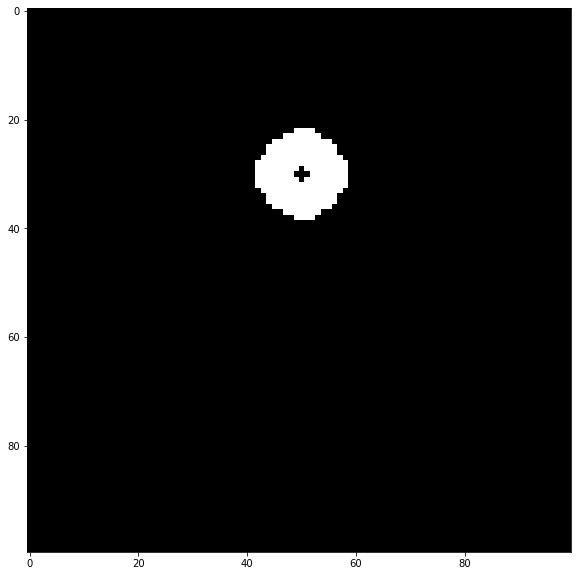

In [8]:
temp_canvas = np.zeros((100, 100, 3))
show(cv2.circle(temp_canvas, (50,30), int(5), [100,100,100], 5,1))